In [ ]:
#!pip install kaggle

# <no!> Ensure your Kaggle API credentials are configured
#!kaggle datasets download -d ferdi4366/image-test-for-capstone2
#!kaggle datasets download -d ferdi4366/dataset-capstone-final

# Please Uncomment All code above except that with "<no!>"  

Dataset URL: https://www.kaggle.com/datasets/ferdi4366/image-test-for-capstone2
License(s): unknown
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 104MB/s]
Dataset URL: https://www.kaggle.com/datasets/ferdi4366/dataset-capstone-final
License(s): unknown
 98% 742M/754M [00:04<00:00, 53.2MB/s]
100% 754M/754M [00:04<00:00, 163MB/s] 


In [10]:
# Example: Unzipping a file named 'dataset.zip' in Colab
!unzip /content/dataset-capstone-final.zip -d /content/dataset-capstone-final
!unzip /content/image-test-for-capstone2.zip -d /content/image-test-for-capstone2


Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset-capstone-final/Dataset Final/pancakes/111124.jpg  
  inflating: /content/dataset-capstone-final/Dataset Final/pancakes/1112662.jpg  
  inflating: /content/dataset-capstone-final/Dataset Final/pancakes/1118505.jpg  
  inflating: /content/dataset-capstone-final/Dataset Final/pancakes/1123229.jpg  
  inflating: /content/dataset-capstone-final/Dataset Final/pancakes/112642.jpg  
  inflating: /content/dataset-capstone-final/Dataset Final/pancakes/1131482.jpg  
  inflating: /content/dataset-capstone-final/Dataset Final/pancakes/1134506.jpg  
  inflating: /content/dataset-capstone-final/Dataset Final/pancakes/1140565.jpg  
  inflating: /content/dataset-capstone-final/Dataset Final/pancakes/1142318.jpg  
  inflating: /content/dataset-capstone-final/Dataset Final/pancakes/1149120.jpg  
  inflating: /content/dataset-capstone-final/Dataset Final/pancakes/1151338.jpg  
  inflating: /content/dataset-capstone-final/Data

# **Import Library**

In [2]:
import tensorflow as tf
import os
import random
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from keras.regularizers import l2

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
data_dir = '/content/dataset-capstone-final/Dataset Final'

In [12]:
filepaths=[]
labels=[]
allowed_extensions = ['.png', '.jpeg', '.jpg']
classlist=os.listdir(data_dir)
for img_class in classlist:
    classpath=os.path.join(data_dir,img_class)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(img_class)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths       labels
0  /content/dataset-capstone-final/Dataset Final/...  Nasi Goreng
1  /content/dataset-capstone-final/Dataset Final/...  Nasi Goreng
2  /content/dataset-capstone-final/Dataset Final/...  Nasi Goreng
3  /content/dataset-capstone-final/Dataset Final/...  Nasi Goreng
4  /content/dataset-capstone-final/Dataset Final/...  Nasi Goreng
labels
Nasi Goreng       1000
hamburger         1000
steak             1000
edamame           1000
sushi             1000
french_fries      1000
hot_dog           1000
sashimi           1000
pancakes          1000
takoyaki           999
Telur Balado       395
Bubur Ayam         283
Bakso              280
Pempek             247
Lontong Balap      226
Rawon              214
Martabak Telur     193
Name: count, dtype: int64


# **Setting Up Directory**

In [13]:
train_dir = '/content/working/train'
os.makedirs(train_dir, exist_ok=True)

test_dir = '/content/working/test'
os.makedirs(test_dir, exist_ok=True)

validation_dir = '/content/working/validation'
os.makedirs(validation_dir, exist_ok=True)

In [14]:
train_ratio = .8
test_ratio = .1
validation_ratio = 1 - (train_ratio + test_ratio)

In [15]:
train_data, validation_data = train_test_split(df, test_size=test_ratio, random_state=123)
train_data, test_data = train_test_split(train_data, test_size=validation_ratio, random_state=123)

In [16]:
# Memindahkan file gambar ke direktori yang sesuai


# Memindahkan file gambar ke direktori train
for index, row in train_data.iterrows():
    file_path = row['filepaths']
    label = row['labels']
    destination_dir = os.path.join(train_dir, label)
    os.makedirs(destination_dir, exist_ok=True)
    shutil.copy(file_path, destination_dir)

# Memindahkan file gambar ke direktori test
for index, row in test_data.iterrows():
    file_path = row['filepaths']
    label = row['labels']
    destination_dir = os.path.join(test_dir, label)
    os.makedirs(destination_dir, exist_ok=True)
    shutil.copy(file_path, destination_dir)

# Memindahkan file gambar ke direktori validation
for index, row in validation_data.iterrows():
    file_path = row['filepaths']
    label = row['labels']
    destination_dir = os.path.join(validation_dir, label)
    os.makedirs(destination_dir, exist_ok=True)
    shutil.copy(file_path, destination_dir)

In [17]:
print ('train_df length: ', len(train_data), '  test_df length: ', len(test_data), '  validation_df length: ', len(validation_data))

train_df length:  9587   test_df length:  1066   validation_df length:  1184


# **Data preprocessing & augmentation**

In [18]:
image_size = (224,224)
batch_size = 20

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

Found 9584 images belonging to 17 classes.
Found 1066 images belonging to 17 classes.
Found 1183 images belonging to 17 classes.


In [19]:
def show_image_samples(gen):
    classes = train_generator.class_indices
    class_names = list(classes.keys())

    images, labels = next(gen)  # Get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length = len(labels)
    if length < 25:  # Show a maximum of 25 images
        r = length
    else:
        r = 25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = images[i]
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = class_names[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

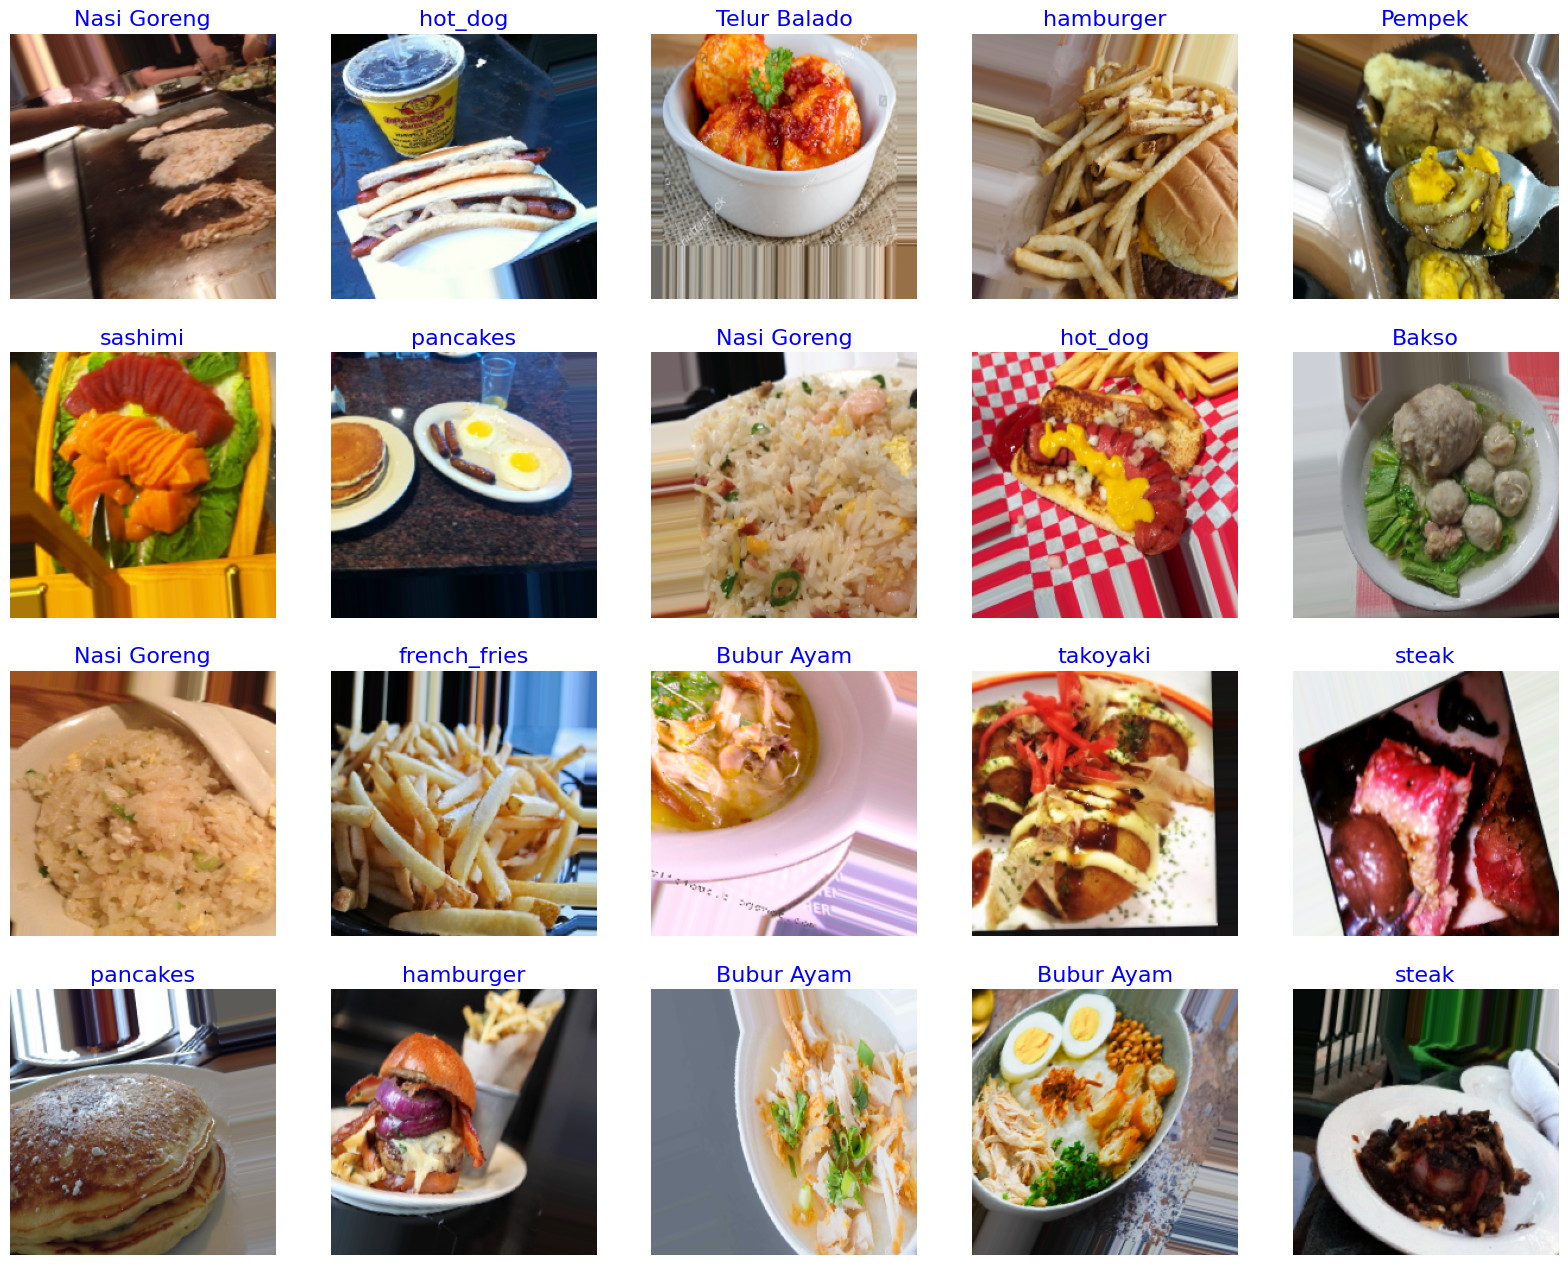

In [20]:
show_image_samples(train_generator)

# **Model Training**
with **Transfer Learning**

In [21]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Dense(256, activation='relu',kernel_regularizer=l2(0.01))(x)  # Tambahkan beberapa layer *dense*
x = Dense(128, activation='relu',kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
output_layer = Dense(17, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)


In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,424,145 (9.25 MB)

 Trainable params: 166,161 (649.07 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [24]:
epochs= 40
verbose = 1


# Callback untuk memberhentikan pelatihan jika val_accuracy tidak meningkat dalam 8 epoch
#early_stopping1 = EarlyStopping(monitor='val_accuracy', patience = 8, mode='max',baseline=0.95,restore_best_weights=True, verbose=1)

# Callback untuk menyimpan model terbaik berdasarkan val_accuracy
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

history = model.fit(
    train_generator,
    epochs=epochs,
    verbose=verbose,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


479/480 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.2344 - loss: 2.7626
Epoch 1: val_accuracy improved from -inf to 0.69231, saving model to best_model.keras
480/480 ━━━━━━━━━━━━━━━━━━━━ 160s 304ms/step - accuracy: 0.2349 - loss: 2.7609 - val_accuracy: 0.6923 - val_loss: 1.4946
Epoch 2/40
479/480 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.5539 - loss: 1.7032
Epoch 2: val_accuracy improved from 0.69231 to 0.75063, saving model to best_model.keras
480/480 ━━━━━━━━━━━━━━━━━━━━ 139s 286ms/step - accuracy: 0.5540 - loss: 1.7029 - val_accuracy: 0.7506 - val_loss: 1.1346
Epoch 3/40
479/480 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.6430 - loss: 1.3936
Epoch 3: val_accuracy improved from 0.75063 to 0.78445, saving model to best_model.keras
480/480 ━━━━━━━━━━━━━━━━━━━━ 137s 281ms/step - accuracy: 0.6430 - loss: 1.3935 - val_accuracy: 0.7844 - val_loss: 0.9972
Epoch 4/40
479/480 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.6907 - loss: 1.2520
Epoch 4: val_accuracy improved f

**Further Model Training with Fine-tune**

In [25]:
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Bekukan sebagian besar layer awal
    layer.trainable = False

In [26]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,756,469 (10.52 MB)

 Trainable params: 1,692,561 (6.46 MB)

 Non-trainable params: 731,584 (2.79 MB)

 Optimizer params: 332,324 (1.27 MB)

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model_finetuned.keras', monitor='val_accuracy', save_best_only=True, verbose=1)


history_finetune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  # Epoch lebih sedikit karena ini fine-tuning
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/20
479/480 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.7033 - loss: 1.0761
Epoch 1: val_accuracy improved from -inf to 0.84193, saving model to best_model_finetuned.keras
480/480 ━━━━━━━━━━━━━━━━━━━━ 161s 299ms/step - accuracy: 0.7034 - loss: 1.0758 - val_accuracy: 0.8419 - val_loss: 0.6389
Epoch 2/20
479/480 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.7822 - loss: 0.8483
Epoch 2: val_accuracy improved from 0.84193 to 0.84446, saving model to best_model_finetuned.keras
480/480 ━━━━━━━━━━━━━━━━━━━━ 135s 277ms/step - accuracy: 0.7822 - loss: 0.8481 - val_accuracy: 0.8445 - val_loss: 0.6342
Epoch 3/20
479/480 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.7951 - loss: 0.7850
Epoch 3: val_accuracy improved from 0.84446 to 0.84615, saving model to best_model_finetuned.keras
480/480 ━━━━━━━━━━━━━━━━━━━━ 134s 277ms/step - accuracy: 0.7952 - loss: 0.7849 - val_accuracy: 0.8462 - val_loss: 0.6146
Epoch 4/20
479/480 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.8031 - loss

# **Evaluate Model**

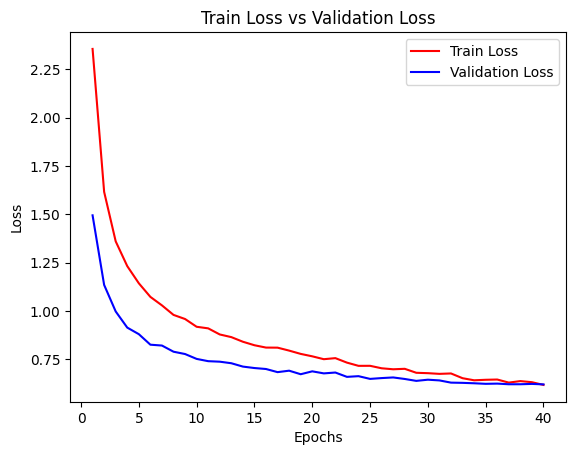

In [29]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot train loss dan validation loss
plt.plot(epochs, train_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Train Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

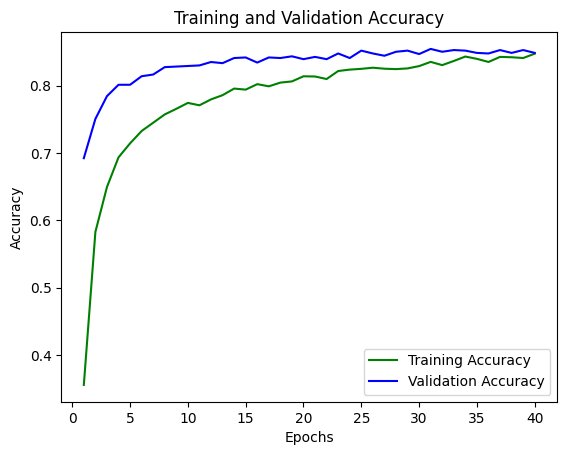

In [30]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
# Evaluasi model (Validasi)
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy:.2f}")

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.8758 - loss: 0.5230
Validation Accuracy: 0.88


In [32]:
# Evaluasi model (test)
test_loss, test_acc = model.evaluate(test_generator)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.8700 - loss: 0.5587
Test Loss: 0.5202934145927429
Test Accuracy: 0.8808630108833313


In [33]:

# Mengumpulkan semua prediksi dan label sebenarnya
y_true = []
y_pred = []

for batch_idx in range(len(validation_generator)):
  # Dapatkan batch data dan label
  images, labels = validation_generator[batch_idx]

  # Prediksi label untuk batch
  predictions = model.predict(images)
  predicted_labels = np.argmax(predictions, axis=1)
  true_labels = np.argmax(labels, axis=1)

  # Tambahkan ke daftar prediksi dan label sebenarnya
  y_true.extend(true_labels)
  y_pred.extend(predicted_labels)

# Menghasilkan classification report
target_names = list(validation_generator.class_indices.keys())  # Nama kelas
report = classification_report(y_true, y_pred, target_names=target_names)

print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━

**Test Using Specialized data set for testing**

In [34]:

def predict_image(img_path):
    # Load image
    img = image.load_img(img_path, target_size=(224, 224))  # Pastikan ukuran gambar sesuai dengan yang diinginkan
    img_array = image.img_to_array(img) / 255.0  # Normalisasi gambar
    img_array = np.expand_dims(img_array, axis=0)  # Menambahkan dimensi batch (None, 224, 224, 3)

    # Prediksi dengan model
    predictions = model.predict(img_array)

    # Mendapatkan label kelas
    class_idx = np.argmax(predictions[0])
    class_label = list(train_generator.class_indices.keys())[class_idx]

    print(f"Predicted Class for {os.path.basename(img_path)}: {class_label}")

def predict_images_in_folder(folder_path):
    # Mengambil semua file gambar dari folder
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        # Memastikan hanya file gambar yang diproses
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            predict_image(img_path)

# Path ke folder yang berisi gambar
test_folder_path = '/content/image-test-for-capstone2/image_test'
predict_images_in_folder(test_folder_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class for pempek (2).jpg: Pempek
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Class for ruajk cingur.jpg: Lontong Balap
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Class for rawon.jpg: Rawon
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Class for dadar2.jpg: Nasi Goreng
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Class for telur dadar.jpg: Nasi Goreng
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Class for rendang2.jpg: Rawon
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Class for Lontong balap2.jpg: Lontong Balap
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Class for nasi goreng.jpg: steak
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Class for Nasi goreng2.jpg: Nasi Goreng
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Class for rendang.jpg: steak
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Class for Lontong balap3.jpg: Rawon
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Class for rendangs.jpg: Rawon
1/1 ━━━━━

# **Label Mapping**
Import to csv

In [35]:
print("Class Indices (Label Mapping):", train_generator.class_indices)

Class Indices (Label Mapping): {'Bakso': 0, 'Bubur Ayam': 1, 'Lontong Balap': 2, 'Martabak Telur': 3, 'Nasi Goreng': 4, 'Pempek': 5, 'Rawon': 6, 'Telur Balado': 7, 'edamame': 8, 'french_fries': 9, 'hamburger': 10, 'hot_dog': 11, 'pancakes': 12, 'sashimi': 13, 'steak': 14, 'sushi': 15, 'takoyaki': 16}


In [36]:
# Dapatkan class indices
class_indices = train_generator.class_indices

# Konversi ke DataFrame
df = pd.DataFrame(list(class_indices.items()), columns=["Class Name", "Label"])

# Simpan ke file CSV
df.to_csv("class_indices.csv", index=False)

print("Class Indices saved to class_indices.csv!")

# Direktori tempat file akan disimpan
directory = "/content/working/my_directory"
filename = "class_indices.csv"
filepath = os.path.join(directory, filename)

# Pastikan direktori ada, jika tidak, buat
os.makedirs(directory, exist_ok=True)

# Dapatkan class indices
class_indices = train_generator.class_indices

# Konversi ke DataFrame
df = pd.DataFrame(list(class_indices.items()), columns=["Class Name", "Label"])

# Simpan ke file CSV di direktori tertentu
df.to_csv(filepath, index=False)

print(f"Class Indices saved to {filepath}!")


Class Indices saved to class_indices.csv!
Class Indices saved to /content/working/my_directory/class_indices.csv!


**Save Model**

In [37]:
model.save('/kaggle/working/Finalm2.h5')